In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import quantstats as qs

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

In [2]:
def get_portfolio_t(df: pd.DataFrame, q: int, method: str):

    df = df.copy()

    def qcut(x):
        x = x.rank(method='first')
        x = pd.qcut(x, q, labels=range(1, q + 1), duplicates='drop')
        return x

    df = df.sort_values(['date', 'qscode']).reset_index(drop=True)
    df['portfolio'] = df.groupby('date')['score'].apply(qcut).reset_index(drop=True)

    top_pattern = r'^Top(\d+)_Equal$'
    top_match = re.match(top_pattern, method)

    percent_pattern = r'^Percent(\d+(\.\d+)?)_Equal$'
    percent_match = re.match(percent_pattern, method)
    
    # 'Equal' weight method
    if method == 'Equal':
        df.sort_values(['date', 'portfolio'], inplace=True)
        df['weights'] = df.groupby(['date', 'portfolio'])['qscode'].transform(lambda x: 1/len(x)).reset_index(drop=True)
        df['weights'] /= q
    # 'Score' weight method
    elif method == 'Score':
        
        def get_weights(x):
            pred_y = x.values
            idx = pred_y.argsort()  # sorted by score
            n = len(pred_y)  # total number of stocks
            # Generate rank weights
            rank_weights = np.arange(1, n+1)
            rank_weights = rank_weights / np.sum(rank_weights)
            # Initialize weights array with zeros
            weights = np.zeros(n)
            # Assign rank weights to all stocks based on their score
            np.put(weights, idx, rank_weights[::-1])  # [::-1] to give highest rank weight to highest score
            weights /= q

            return pd.Series(weights, index=x.index)

        df.sort_values(['date', 'portfolio'], inplace=True)
        df['weights'] = df.groupby(['date', 'portfolio'])['score'].apply(get_weights).reset_index(drop=True)
    elif top_match:
        n = int(top_match.group(1))
        df['portfolio'] = 3
        largest_index = [idx[-1] for idx in df.groupby('date')['score'].nlargest(n).index]
        lowest_index = [idx[-1] for idx in df.groupby('date')['score'].nsmallest(n).index]
        df.loc[largest_index, 'portfolio'] = 5
        df.loc[lowest_index, 'portfolio'] = 1
        df['weights'] = 1 / n / q
    elif percent_match:
        n = float(percent_match.group(1))
        n = int(df.shape[0] * n)
        df['portfolio'] = 3
        largest_index = [idx[-1] for idx in df.groupby('date')['score'].nlargest(n).index]
        lowest_index = [idx[-1] for idx in df.groupby('date')['score'].nsmallest(n).index]
        df.loc[largest_index, 'portfolio'] = 5
        df.loc[lowest_index, 'portfolio'] = 1
        df['weights'] = 1 / n / q
    else:
        raise ValueError(f"Invalid parameter method. Choose either 'Equal' or 'Score', get {method} instead.")

    return df


def backtest_t_fee(df: pd.DataFrame, q: int, sign: int, save_dir: str, model_name: str, method: str, T: int, weight_method: str, FEE_RATE: float):
    """
    Backtest

    Args: 
        df - dataframe of results, with category of portfolios saved in column named portfolio
        q - number of groups
        sign - indicator of factor sign
    """

    if not os.path.exists(f"{save_dir}/Report"):
        os.makedirs(f"{save_dir}/Report")

    df = df.copy()

    # Create dictionary with dates and corresponding portfolio
    if sign == 1:
        pools_dict = df[df['portfolio']==q].groupby('date').apply(lambda subf: subf[['qscode', 'weights']].set_index('qscode').to_dict()['weights'])
    elif sign == -1: 
        pools_dict = df[df['portfolio']==1].groupby('date').apply(lambda subf: subf[['qscode', 'weights']].set_index('qscode').to_dict()['weights'])
    else: 
        raise ValueError(f'Parameter sign should be +1/-1, get {sign} instead')
    
    pools_dict = {pd.to_datetime(k): v for k, v in pools_dict.items()}

    # Create 5-day rolling dictionary
    daily_portfolio = {}  # the portfolio we hold on each day
    diffed_portfolio = {}
    for i in range(T, len(pools_dict)):
    # for i in range(5, 20):
        dates = list(pools_dict.keys())
        curr_date = dates[i]
        past_5_dates = dates[i-5:i]

        today_portfolio = {}
        for date in past_5_dates:
            portfolio_to_add = pools_dict[date]
            for stock, weight in portfolio_to_add.items():
                today_portfolio[stock] = today_portfolio.get(stock, 0) + weight
        # Add the portfolio bought today
        portfolio_to_add = pools_dict[curr_date]
        portfolio_to_sell = pools_dict[past_5_dates[0]]
        # Calculate difference for overlapping stocks
        combined_portfolio = {key: portfolio_to_add.get(key, 0) - portfolio_to_sell.get(key, 0) for key in set(portfolio_to_add) | set(portfolio_to_sell)}
        diffed_value = 0
        for stock, weight in combined_portfolio.items():
            today_portfolio[stock] = today_portfolio.get(stock, 0) + weight
            diffed_value += abs(combined_portfolio.get(stock, 0))

        diffed_portfolio[curr_date] = diffed_value * FEE_RATE
        daily_portfolio[curr_date] = today_portfolio

    # Create DataFrame with date-qscode-weight
    index_df = pd.DataFrame([(k, *kv) for k, v in daily_portfolio.items() for kv in v.items()], columns=['date', 'qscode', 'weight'])
    diffed_df = pd.DataFrame([(k, v) for k, v in diffed_portfolio.items()], columns=['date', 'fee'])
    # Merge with original DataFrame to get return information
    df['date'] = pd.to_datetime(df['date'])
    merged_df = index_df.merge(df, on=['date', 'qscode'], how='left')
    # Calculate portfolio return by date
    merged_df['weighted_return'] = merged_df['weight'] * merged_df['return']
    portfolio_returns = merged_df.groupby('date')['weighted_return'].sum().reset_index().rename(columns={'weighted_return': 'portfolio_return'})

    # Calculate and add benchmark return
    benchmark_df = df.groupby('date')['return'].mean().reset_index().rename(columns={'return': 'benchmark'})
    portfolio_returns = portfolio_returns.merge(benchmark_df, on=['date'])
    portfolio_returns = portfolio_returns.merge(diffed_df, on=['date'], how='left')
    portfolio_returns['portfolio_return'] -= portfolio_returns['fee']
    portfolio_returns = portfolio_returns.set_index(['date'])
    portfolio_returns.index = pd.to_datetime(portfolio_returns.index)

    print(portfolio_returns)

    qs.reports.plots(portfolio_returns['portfolio_return'], portfolio_returns['benchmark'])
    plt.show()
    plt.close()

    report_dir = f'{save_dir}/Report/{model_name}_{method}_{q}_{sign}_{FEE_RATE}_{weight_method}_t.html'
    qs.reports.html(portfolio_returns['portfolio_return'], portfolio_returns['benchmark'], 
                    download_filename=report_dir,
                    title=f'Strategy conducted by model {model_name}',
                    output='yes')

In [3]:
save_dir = 'D:/杨钦/计算机语言与笔记/quant/牧鑫/机器学习'
model_name = 'LSTM'
loss_name = 'ListNet'
q = 5
method = 'Top100_Equal'
T = 5
FEE_RATE = 0.003
sign = 1

df = pd.read_csv(f'D:/杨钦/计算机语言与笔记/quant/牧鑫/机器学习/{model_name}_{loss_name}_2014_6_2023_5.csv')
df.sample(5)

,qscode,date,return,score
159148,002611.SZ,2020-06-24,0.000000,-0.026640
174100,300292.SZ,2020-10-09,0.029126,-0.088998
256743,300579.SZ,2021-04-21,0.034130,-0.053302
44467,300738.SZ,2019-09-02,-0.003924,-0.048350
75699,000988.SZ,2020-04-13,0.017073,-0.062843


In [4]:
p = get_portfolio_t(df, q, method)
p.sample(5)

,qscode,date,return,score,portfolio,weights
276289,603602.SH,2021-04-22,-0.015611,-0.021822,3,0.002
179357,002456.SZ,2020-08-28,-0.011500,-0.075250,3,0.002
82746,603128.SH,2019-12-27,0.004815,-0.059275,3,0.002
315477,300212.SZ,2021-07-26,0.000000,-0.011414,3,0.002
395029,300597.SZ,2022-01-28,-0.001121,-0.018333,3,0.002


            portfolio_return  benchmark       fee
date                                             
2019-06-11         -0.006066  -0.003328  0.000180
2019-06-12          0.007650   0.006099  0.000180
2019-06-13         -0.019710  -0.023596  0.000204
2019-06-14         -0.000641   0.000759  0.000168
2019-06-17          0.003482   0.001356  0.000144
...                      ...        ...       ...
2023-06-14         -0.002611  -0.000702  0.000132
2023-06-15          0.004324   0.014769  0.000180
2023-06-16         -0.003971   0.012590  0.000180
2023-06-19         -0.006404   0.002881  0.000180
2023-06-20         -0.010712  -0.029959  0.000180

[978 rows x 3 columns]


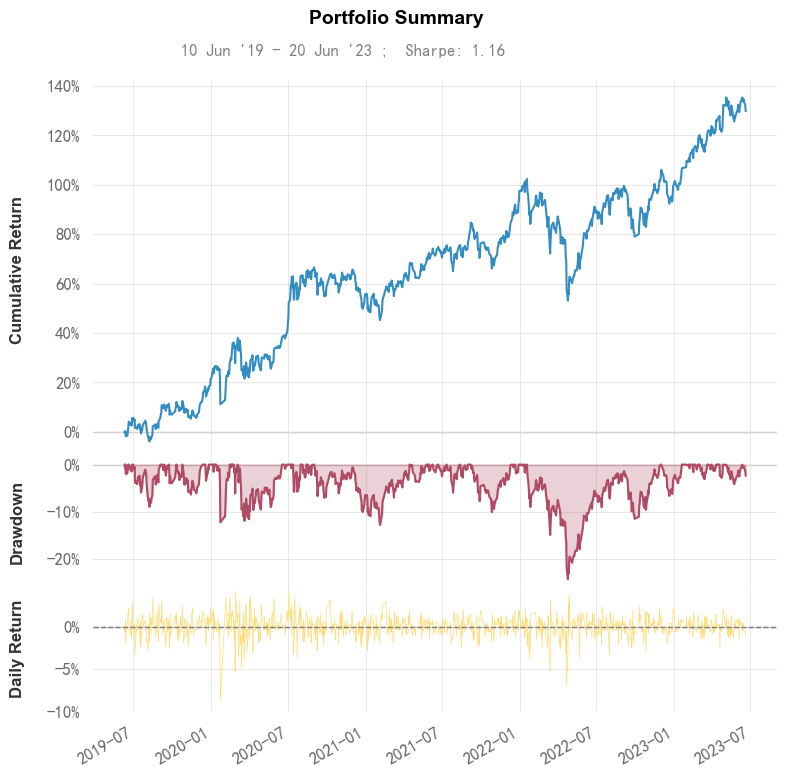

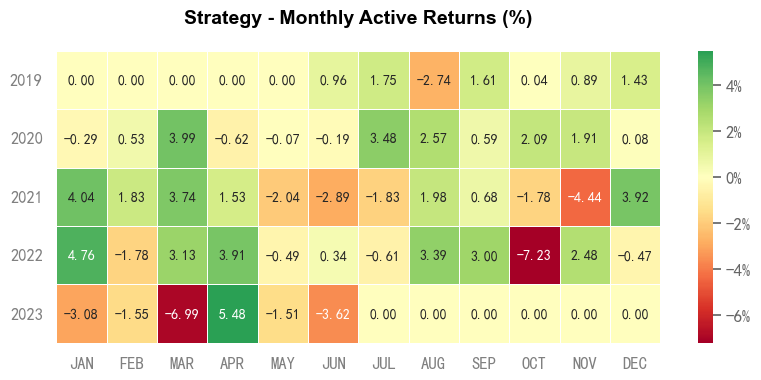

In [5]:
backtest_t_fee(p, q, sign, save_dir, model_name, loss_name, T, method, FEE_RATE)